In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

setwd("~/Repositories/AirQualityCOVID/")

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=15,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
variable <- "no2"
html.variable <- c("no" = "NO",
                   "no2" = "NO<sub>2</sub>",
                   "o3" = "O<sub>3</sub>",
                   "pm10" = "PM10",
                   "pm2.5" = "PM2.5"
                  )
method <- "lm"

In [4]:
load(paste("data/Analysis/predictions-",
           method,"-", variable,".rda", sep=""))

sites.lv <- read.csv("data/Curation/checked_AQ.csv") %>%
            filter(Pollutant == variable) 

In [5]:
results <- merge(sites.lv,
                results,
                by = "site", all.y=T
               ) %>% 
        group_by(date, Municipio) %>%
        summarise(obs = mean(obs, na.rm=T),
                  pred.qq = mean(pred.qq, na.rm=T)
                 )

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



In [6]:
head(results)

date,Municipio,obs,pred.qq
<date>,<chr>,<dbl>,<dbl>
2020-01-01,Alcalá de Henares,42.75000,62.69325
2020-01-01,Alcobendas,53.41667,68.08524
2020-01-01,Alicante,29.29167,41.90218
2020-01-01,Almería,23.66667,34.49937
2020-01-01,Barcelona,39.81250,86.48439
2020-01-01,Bilbao,32.63889,60.29926


In [7]:
results$diff <- results$obs - results$pred.qq

results <- openair::timeAverage(results, 
                                avg.time = "2 day", 
                                type = c("Municipio")
                               )
results$date <- lubridate::as_date(results$date)

In [8]:
head(results)

Municipio,date,obs,pred.qq,diff
<fct>,<date>,<dbl>,<dbl>,<dbl>
Alcalá de Henares,2020-01-01,47.70833,64.05809,-16.349756
Alcalá de Henares,2020-01-03,45.45833,49.51209,-4.053761
Alcalá de Henares,2020-01-05,45.43750,75.66063,-30.223128
Alcalá de Henares,2020-01-07,66.57609,78.97657,-12.400478
Alcalá de Henares,2020-01-09,48.50000,50.18500,-1.685000
Alcalá de Henares,2020-01-11,49.16667,66.00129,-16.834627


# Lockdown dates

In [9]:
periods <- list(
    # Prelockdown
    #pre.lockdown = lubridate::ymd("2020-01-01"),

    # lockdown
    lockdown = lubridate::ymd("2020-03-14"),
    #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

    # poslockdown
    fases = lubridate::ymd("2020-05-01"),
    normalidad = lubridate::ymd("2020-06-21"),

    # New lockdown
    new.lockdown = lubridate::ymd("2020-10-25")#,
    #end.year = lubridate::ymd("2020-11-26")
)

## Breakpoints

## Using `segmented` package

In [10]:
suppressMessages(library(segmented))
suppressMessages(library(plyr))

In [11]:
segment.data <- function(pll, data.df, init.seg) {
    data.df <- data.df %>% filter(Municipio == pll)
    
    for (i in 1:length(init.seg)) {
        if (min(data.df$date) >= init.seg[i]) {
            init.seg <- init.seg[(i+1):length(init.seg)]
            break
        }
    }
    
    for (i in 1:length(init.seg)) {
        if (max(data.df$date) <= init.seg[i]) {
            init.seg <- init.seg[1:(i-1)]
            break
        }
    }
    
    my.seg <- segmented(lm(diff ~ date + 1, data=data.df), 
                      seg.Z = ~date,
                      psi = init.seg
                     )

    if (is.null(nrow(my.seg$psi))) {
        return()
    }
    
    return(cbind(data.frame(Municipio=pll),
                 my.seg$psi))
}


In [12]:
seg.df <- do.call(rbind.fill, 
                  lapply(levels(as.factor(results$Municipio)), 
                         segment.data, results, unlist(periods))) %>% drop_na()

Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”
Warning message:
“No breakpoint estimated”


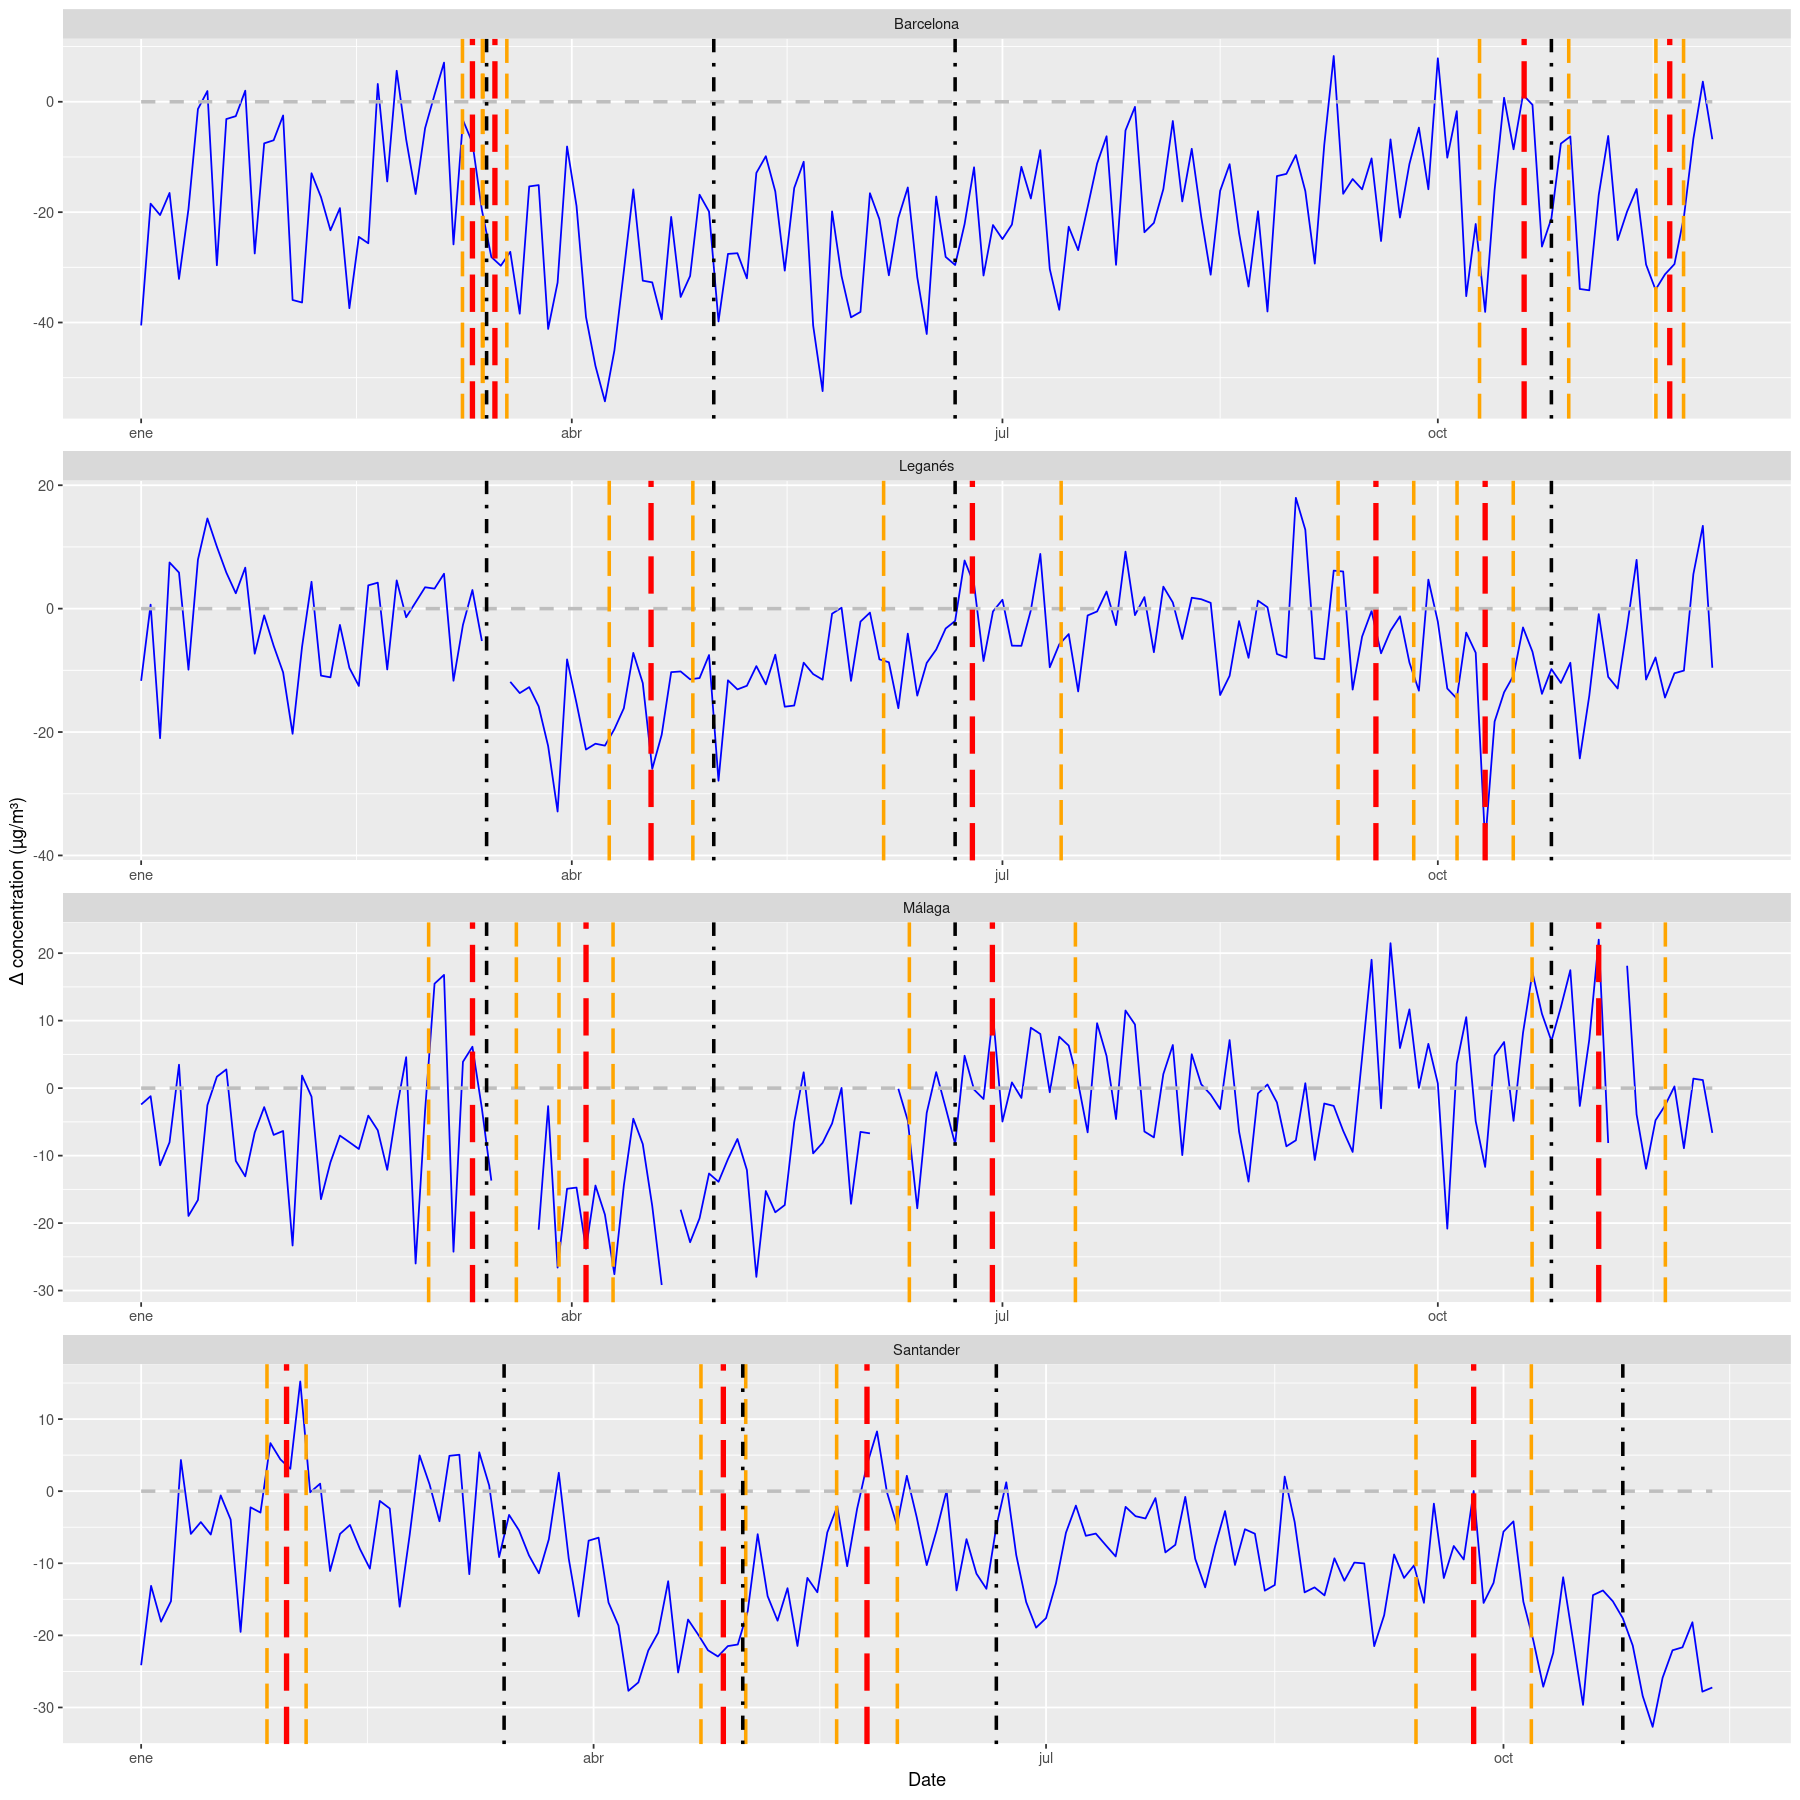

In [13]:
plot <- ggplot(data=results %>% filter(Municipio %in% c("Leganés", 
                                                        "Santander", 
                                                        "Barcelona", 
                                                        "Málaga")),
                                       aes(x=lubridate::as_date(date)))+ 
    geom_line(aes(y=diff), color="blue", size=0.5) +
    geom_line(aes(y=0), color="gray", linetype=2, size=1) +
    xlab("Date") + ylab("\u0394 concentration (\u00b5g/m\u00b3)") +
    facet_wrap(~Municipio, ncol=1, scale="free")

plot <- plot +
    geom_vline(data=seg.df %>% filter(Municipio %in% c("Leganés", 
                                                        "Santander", 
                                                        "Barcelona", 
                                                        "Málaga")), aes(xintercept = Est.), 
               linetype=5, color = "red", size=1.5) +
    geom_vline(data=seg.df %>% filter(Municipio %in% c("Leganés", 
                                                        "Santander", 
                                                        "Barcelona", 
                                                        "Málaga")), aes(xintercept = Est.+St.Err), 
               linetype=5, color = "orange", size=1) +
    geom_vline(data=seg.df %>% filter(Municipio %in% c("Leganés", 
                                                        "Santander", 
                                                        "Barcelona", 
                                                        "Málaga")), aes(xintercept = Est.-St.Err), 
               linetype=5, color = "orange", size=1)

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot